# Project: Predicting Boston Housing Prices
## Model Evaluation & Validation

## Getting Started
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.


In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')

# Sample print of the datasets
data.head(10)


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0
5,6.430,5.21,18.7,602700.0
6,6.012,12.43,15.2,480900.0
7,6.172,19.15,15.2,569100.0
8,5.631,29.93,15.2,346500.0
9,6.004,17.10,15.2,396900.0


In [4]:
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, we will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

In [5]:
# TODO: Minimum price of the data
minimum_price = np.amin(prices)

# TODO: Maximum price of the data
maximum_price = np.amax(prices)

# TODO: Mean price of the data
mean_price = np.mean(prices)

# TODO: Median price of the data
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


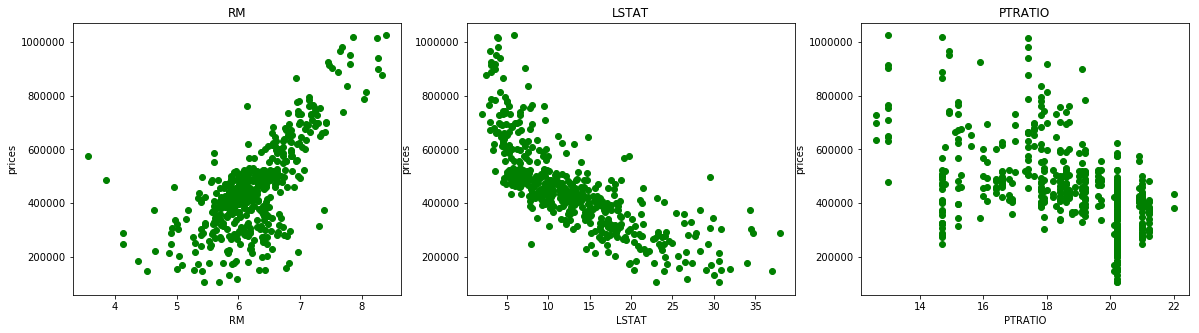

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'go') ## 'g' in go here suggests green color;'o' stands for circles on the plot
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

###  Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

'RM' - An increase in value of this feature would increase the value of the 'MEDV'. A house with 7 rooms will be worth more than a house with 6 rooms because of the area (sq ft) of the house.<br>

'LSTAT' - An increase in value of this feature would decrease the value of 'MEDV' because "lower class" homeowners might not be able to afford houses around or above the average cost leading to a lower 'MEDV'. <br>

'PTRATIO' - An increase in the value of this feature would decrease the value of the 'MEDV' because the higher the student to teacher ratio means less teachers to accomodate for the growing number of students. Parents would rather prefer a decent / low student to teacher ratio so that their child may get the proper education with good attention from the teachers.

----

## Developing a Model


### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, we will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [7]:
# TODO: Import 'r2_score'

from sklearn.metrics import r2_score
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

In [8]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


**Answer:** Based on the coefficient of Determination values , r^2, we would consider this model to have successfully captured the variation of the target variable. A values of r^2 close to 1 states that our model is capable of predictinng the values of dependent variable from the independennt variables with only slight error margin.

### Implementation: Shuffle and Split Data
Next step is to take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [9]:
# TODO: Import 'train_test_split'
from sklearn import cross_validation as cv

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = cv.train_test_split(features, prices, test_size =0.2, random_state = 0)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


### Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*  

**Answer: ** When we build a model, based on the features we have used, model might over fit or under fit the data and provide wrong predictions. To avoid this scenario, it is important to validate your model before using it. To perform this model validation, we split the data into training and testing data sets, where training data set is used to train the model, whereas, the testing data set is used to validate your model.


----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  


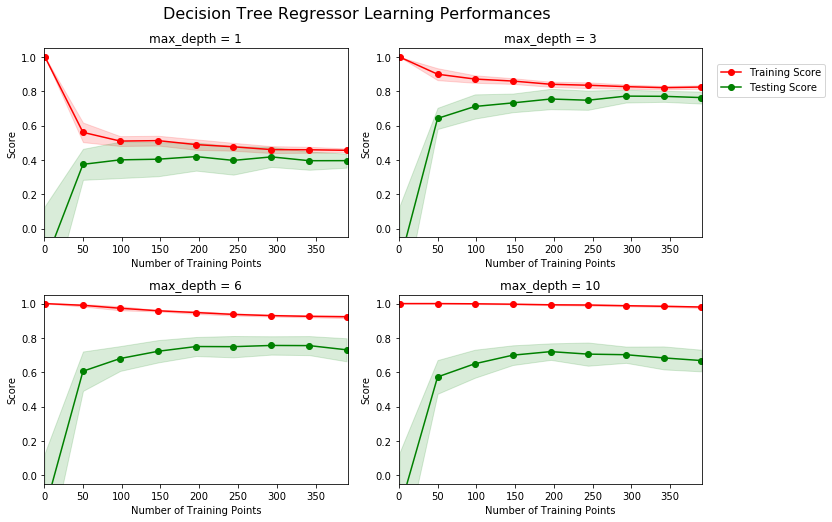

In [10]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*  

**Answer: ** Looking at the graphs above, model with a parameter **max_depth = 3** is the best performing model because as the training points are increasing, both the curves starts converging at a better score than any of the other graphs. Initial trend of both curves, training and testing curves, show a exponential fall / growth respectively when we have a dataset with less than 50 training points. As more training points are added to the data, the score of the training curve starts declining. Whereas, the score of testing curve increases exponentially when the training data points goes till 50 and then keep increasing steadily. As we can see, as the training data points increases, Testing and Training curves starts converging approximately at score 0.75. <br>

After a certain number of training points all the testing scores reached a plateau and fluctuate in a very narrow range sometime even have a down trend. Since the training scores are going down gradually, testing scores are unlikely to be better than training scores in most cases, we can assume that additional training points would not benefit the model.



### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  


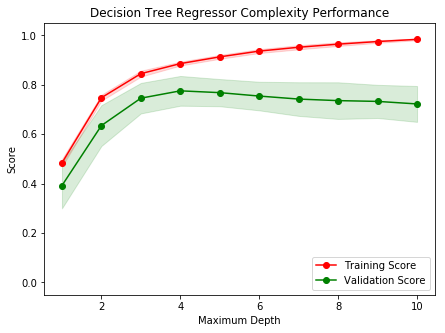

In [11]:
vs.ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*  

**Answer: **  Looking at the graph above, when the model is trained at depth of 1, training and validation scores are approximately at 0.4. At such a low score we can conclude that at depth of 1 model is not able to establish the relevant relations between features and target outputs i.e. model is underfitting the data. Due to randomness in the underlying data sets (At a depth of 1), the resulting model will have a range of predictions which makes the model highly biased and thus it unnder fits the data. <br>
<p>Whereas, when the model is trained at depth of 10, at a training score of 1 we can conclude that the model has over fitted the data. High variance can cause overfitting by modeling the random noise in the training data, rather than the intended outputs. We can see a noticable difference in the score for Training and validation which is caused by over fitted training model.


### Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer: **Looking at the Learning Curves and the Complexity Curves, we can conclude that the model trained at a depth of 4 gives us the most robust and generalized model which can be used for further predictions. <br>
<p> In both, learning and Complexity curves, Training and Testing / validation scores converges at approximately 0.75 when we train the model at a depth of 4. At a depth of 4, we have a model with a constant good performance (score of ~0.75) which makes it a robust and a generalized model.



-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer: ** Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. It generates candidates from a grid of parameter values specified with the param_grid parameter. Grid serch can help us to tune our algorithm to find the best algorithm parameters for the optimal model.

###  Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  

**Answer: ** Cross Validation is a technique which involves reserving a particular sample of a data set on which you do not train the model. Later, you test the model on this sample before finalizing the model. <br>

<p>In K-fold cross validation dataset gets randomly split into k folds. For each k folds in your dataset, build your model on k – 1 folds of the data set. Then, test the model to check the effectiveness on kth fold. The average of your k recorded errors is called the cross-validation error and will serve as your performance metric for the model. For instance, if we split the dataset of 100 points into even subsets of 10 (k=10), each fold we would set aside 1 set for testing and the other 9 for training. <br>
Benefits of k-fold cross-validation:
* More reliable estimate of out-of-sample performance than train/test split.
* Reduce the variance of a single trial of a train/test split. <br>

Hence, with the benefits of k-fold cross-validation, we're able to use the average testing accuracy as a benchmark to decide which is the most optimal set of parameters for the learning algorithm.
If we do not use a cross-validation set and we run grid-search, we would have different sets of optimal parameters due to the fact that without a cross-validation set, the estimate of out-of-sample performance would have a high variance (over-fitting).



### Implementation: Fitting a Model
Our final implementation requires that we bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, we will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [12]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'

from sklearn import grid_search
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=0)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = grid_search.GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. We can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Optimal Model
*What maximum depth does the optimal model have?* 


In [13]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


**Answer: ** After the results of grid search, we can see that we have maximum depth of 4 for the optimal model.

### Predicting Selling Prices
Imagine that a real estate agent in the Boston area is looking to use this model to help price homes owned by his / her clients that they wish to sell. He has collected the following information from three of his / her clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  

In [14]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $391,183.33
Predicted selling price for Client 2's home: $189,123.53
Predicted selling price for Client 3's home: $942,666.67


In [15]:
features.describe()

,RM,LSTAT,PTRATIO
count,489.000000,489.000000,489.000000
mean,6.240288,12.939632,18.516564
std,0.643650,7.081990,2.111268
min,3.561000,1.980000,12.600000
25%,5.880000,7.370000,17.400000
50%,6.185000,11.690000,19.100000
75%,6.575000,17.120000,20.200000
max,8.398000,37.970000,22.000000


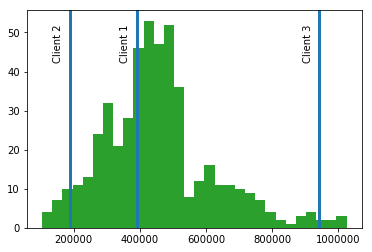

In [16]:
import matplotlib.pyplot as plt
for i,price in enumerate(reg.predict(client_data)):
    plt.hist(prices, bins = 30)
    plt.axvline(price, lw = 3)
    plt.text(price-50000, 50, 'Client '+str(i+1), rotation=90)

We could also plot the client data against the dataset to get a better view of their features

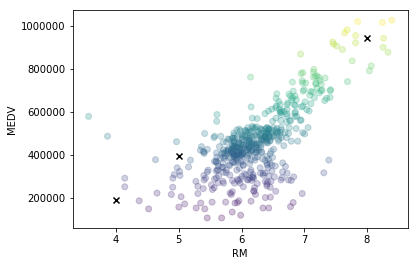

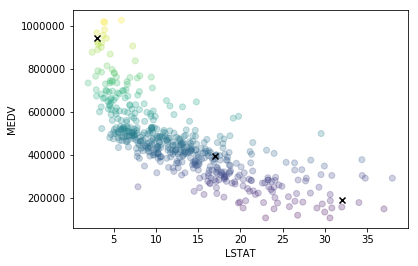

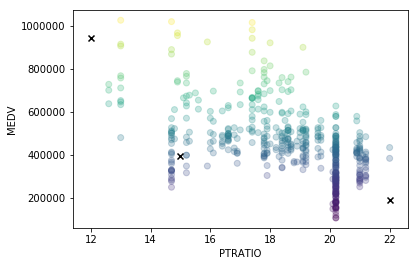

In [27]:
clients = np.transpose(client_data)
pred = reg.predict(client_data)
for i, feat in enumerate(['RM','LSTAT','PTRATIO']):
    plt.scatter(features[feat],prices, alpha=0.25,c=prices)
    plt.scatter(clients[i],pred,c='black', marker='x',linewidths=2)
    plt.xlabel(feat)
    plt.ylabel('MEDV')
    plt.show()

**Answer: ** The values predicted by the model are the values we would be recommendinng to our clients to sell his/her home at. The values predicted by the model seems reasonable when we compare the values with the general statistical value for prices we checked earlier. All the predicted values are betweenn minimum and the maximum price values. <br>
<p>For client 1, the house price is more than Client 2 because of one extra room, the less (almost half) neighbourhood poverty level as well as better Student-teacher ratio of nearby schools. The house price for Client 3 is more because of the better values of all the features we have been provided with to make a decision on house pricing.

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [17]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39
